# Bayesian uncertainty analysis
*R.A. Collenteur, Eawag, June, 2023*

In this notebook it is shown how the MCMC-algorithm can be used to estimate the model parameters and quantify the (parameter) uncertainties for a Pastas model using a Bayesian approach. For this the EmceeSolver is introduced, based on the [emcee](https://emcee.readthedocs.io) Python package. 

Besides Pastas the following Python Packages have to be installed to run this notebook:

- [emcee](https://emcee.readthedocs.io)
- [corner](https://corner.readthedocs.io)

<div class="alert alert-warning">
<b>Note:</b>
The EmceeSolver is still an experimental feature and some of the arguments might be changed in the near future (2023/06/22). We welcome testing and feedback on this new feature!.
</div>

In [1]:
import numpy as np
import pandas as pd

import pastas as ps
import emcee
import corner

import matplotlib.pyplot as plt

ps.set_log_level("ERROR")
ps.show_versions()

Python version: 3.11.3
NumPy version: 1.23.5
Pandas version: 1.5.3
SciPy version: 1.10.1
Matplotlib version: 3.7.1
Numba version: 0.57.0
LMfit version: Not Installed
Latexify version: Not Installed
Pastas version: 1.1.0


## 1. Create a Pastas Model
The first step is to create a Pastas Model, including the RechargeModel to simulate the effect of precipitation and evaporation on the heads. Here, we first estimate the model parameters using the standard least-squares approach.

Fit report head                      Fit Statistics
nfev    51                     EVP            89.38
nobs    351                    R2              0.89
noise   True                   RMSE            0.07
tmin    1990-01-01 00:00:00    AIC         -2061.25
tmax    2005-10-14 00:00:00    BIC         -2030.37
freq    D                      Obj             0.47
warmup  3650 days 00:00:00     ___                 
solver  LeastSquares           Interp.           No

Parameters (8 optimized)
                optimal   stderr     initial   vary
rch_A          0.426127   ±6.04%    0.630436   True
rch_n          0.670369   ±3.00%    1.000000   True
rch_a        296.713506  ±13.63%   10.000000   True
rch_srmax     53.419660   ±5.69%  250.000000   True
rch_lp         0.250000     ±nan    0.250000  False
rch_ks        19.840541  ±11.07%  100.000000   True
rch_gamma      3.961172   ±9.20%    2.000000   True
rch_kv         1.000000     ±nan    1.000000  False
rch_simax      2.000000     ±nan    2.

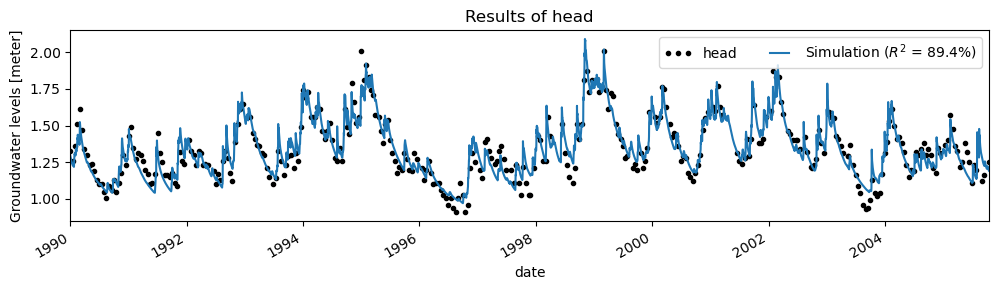

In [2]:
head = pd.read_csv("data/B32C0639001.csv", parse_dates=["date"], index_col="date").squeeze()

# Make this millimeters per day
evap = pd.read_csv("data/evap_260.csv", index_col=0, parse_dates=[0]).squeeze()
rain = pd.read_csv("data/rain_260.csv", index_col=0, parse_dates=[0]).squeeze()

ml = ps.Model(head)

# Select a recharge model
rch = ps.rch.FlexModel()

rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma(), name="rch")
ml.add_stressmodel(rm)

ml.solve(noise=True, tmin="1990")

ax = ml.plot(figsize=(10, 3))

## 2. Use the EmceeSolver

We will now use the EmceeSolve solver to estimate the model parameters and their uncertainties. This solver wraps the [Emcee](https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.Minimizer.emcee) package, which implement different versions of MCMC. A good understanding of Emcee helps when using this solver, so it comes recommended to check out their documentation as well.

To set up the solver, a number of decisions need to be made:

- Determine the priors of the parameters
- Choose a (log) likelihood function
- Choose the number of steps and thinning

### 2a. Choose and set the priors

The first step is to choose and set the priors of the parameters. This is done by using the `ml.set_parameter` method and the `dist` argument (from distribution). Any distribution from the `scipy.stats` can be chosen (https://docs.scipy.org/doc/scipy/tutorial/stats/continuous.html), for example `uniform`, `norm`, or `lognorm`. Here, for the sake of the example, we set all prior distributions to a normal distribution.

In [3]:
# Set the initial parameters to a normal distribution
for name in ml.parameters.index:
    ml.set_parameter(name, dist="norm")

ml.parameters

,initial,name,optimal,pmin,pmax,vary,stderr,dist
rch_A,0.630436,rch,0.426127,0.00001,63.043598,True,0.025728,norm
rch_n,1.000000,rch,0.670369,0.01000,100.000000,True,0.020096,norm
rch_a,10.000000,rch,296.713506,0.01000,10000.000000,True,40.455567,norm
rch_srmax,250.000000,rch,53.419660,0.00001,1000.000000,True,3.037997,norm
rch_lp,0.250000,rch,0.250000,0.00001,1.000000,False,NaN,norm
rch_ks,100.000000,rch,19.840541,0.00001,10000.000000,True,2.196417,norm
rch_gamma,2.000000,rch,3.961172,0.00001,20.000000,True,0.364272,norm
rch_kv,1.000000,rch,1.000000,0.25000,2.000000,False,NaN,norm
rch_simax,2.000000,rch,2.000000,0.00000,10.000000,False,NaN,norm
constant_d,1.359779,constant,0.805810,NaN,NaN,True,0.033039,norm


Pastas will use the `initial` value of the parameter for the `loc` argument of the distribution (e.g., the mean of a normal distribution), and the `stderr` as the `scale` argument (e.g., the standard deviation of a normal distribution). Only for the parameters with a `uniform` distribution, the `pmin` and `pmax` values are used to determine a uniform prior. By default, all parameters are assigned a `uniform` prior.

### 2b. Create the solver instance

The next step is to create an instance of the `EmceeSolve` solver class. At this stage all the settings need to be provided on how the Ensemble Sampler is created (https://emcee.readthedocs.io/en/stable/user/sampler/). Important settings are the `nwalkers`, the `moves`, the `objective_function`. More advanced options are to parallelize the MCMC algorithm (`parallel=True`), and to set a backend to store the results. Here's an example:

In [4]:
# Choose the objective function
ln_prob = ps.objfunc.GaussianLikelihoodAr1()

# Create the EmceeSolver with some settings
s = ps.EmceeSolve(
    nwalkers=20,
    moves=emcee.moves.DEMove(),
    objective_function=ln_prob,
    progress_bar=True,
    parallel=False,
)

In the above code we created an `EmceeSolve` instance with 20 walkers, which take steps according to the `DEMove` move algorithm (see Emcee docs), and a Gaussian likelihood function that assumes AR1 correlated errors. Different objective functions are available, see the Pastas documentation on the different options. 

Depending on the likelihood function a number of additional parameters need to be inferred. These parameters are not added to the Pastas Model instance, but are available from the solver object. Using the `set_parameter` method of the solver, these parameters can be changed.

In [5]:
s.parameters

,initial,pmin,pmax,vary,stderr,name,dist
ln_sigma,0.05,1.000000e-10,1.00000,True,0.01,ln,uniform
ln_alpha,0.50,1.000000e-10,0.99999,True,0.20,ln,uniform


In [6]:
s.set_parameter("ln_sigma", initial=0.0028, vary=False, dist="norm")
s.parameters

,initial,pmin,pmax,vary,stderr,name,dist
ln_sigma,0.0028,1.000000e-10,1.00000,False,0.01,ln,norm
ln_alpha,0.5000,1.000000e-10,0.99999,True,0.20,ln,uniform


### 2c. Run the solver and solve the model

After setting the parameters and creating a EmceeSolve solver instance we are now ready to run the MCMC analysis. We can do this by running `ml.solve`. We can pass the same parameters that we normally provide to this method (e.g., `tmin` or `fit_constant`). Here we use the initial parameters from our least-square solve, and do not fit a noise model (`noise=False`), because we take autocorrelated errors into account through the likelihood function. 

All the arguments that are not used by `ml.solve`, for example `steps` and `tune`, are passed on to the `run_mcmc` method from the sampler (see Emcee docs). The most important is the `steps` argument, that determines how many steps each of the walkers takes.

In [7]:
# Use the solver to run MCMC
ml.solve(
    solver=s,
    initial=False,
    fit_constant=False,
    noise=False,  # We have to set noise to False !
    tmin="1990",
    steps=1000,
    tune=True,
)

100%|███████████████████████████████████████| 1000/1000 [00:36<00:00, 27.20it/s]

Fit report head                   Fit Statistics
nfev    nan                    EVP         89.39
nobs    351                    R2           0.89
noise   False                  RMSE         0.07
tmin    1990-01-01 00:00:00    AIC      -1877.69
tmax    2005-10-14 00:00:00    BIC      -1854.52
freq    D                      Obj           nan
warmup  3650 days 00:00:00     ___              
solver  EmceeSolve             Interp.        No

Parameters (6 optimized)
               optimal stderr     initial   vary
rch_A         0.422096   ±nan    0.426127   True
rch_n         0.668074   ±nan    0.670369   True
rch_a       296.640788   ±nan  296.713506   True
rch_srmax    53.322530   ±nan   53.419660   True
rch_lp        0.250000   ±nan    0.250000  False
rch_ks       19.889189   ±nan   19.840541   True
rch_gamma     4.054211   ±nan    3.961172   True
rch_kv        1.000000   ±nan    1.000000  False
rch_simax     2.000000   ±nan    2.000000  False
constant_d    0.812880   ±nan    0.000000  

## 3. Posterior parameter distributions

The results are stored in the `result` object, accessible through `ml.fit.sampler` variable. The object `ml.fit.sampler.flatchain` contains a Pandas DataFrame with $n$ the parameter samples, where $n$ is calculated as follows:

$n = \frac{\left(\text{steps}-\text{burn}\right)\cdot\text{nwalkers}}{\text{thin}} $

## Corner.py
Corner is a simple but great python package that makes creating corner graphs easy. A couple of lines of code suffice to create a plot of the parameter distributions and the covariances between the parameters.

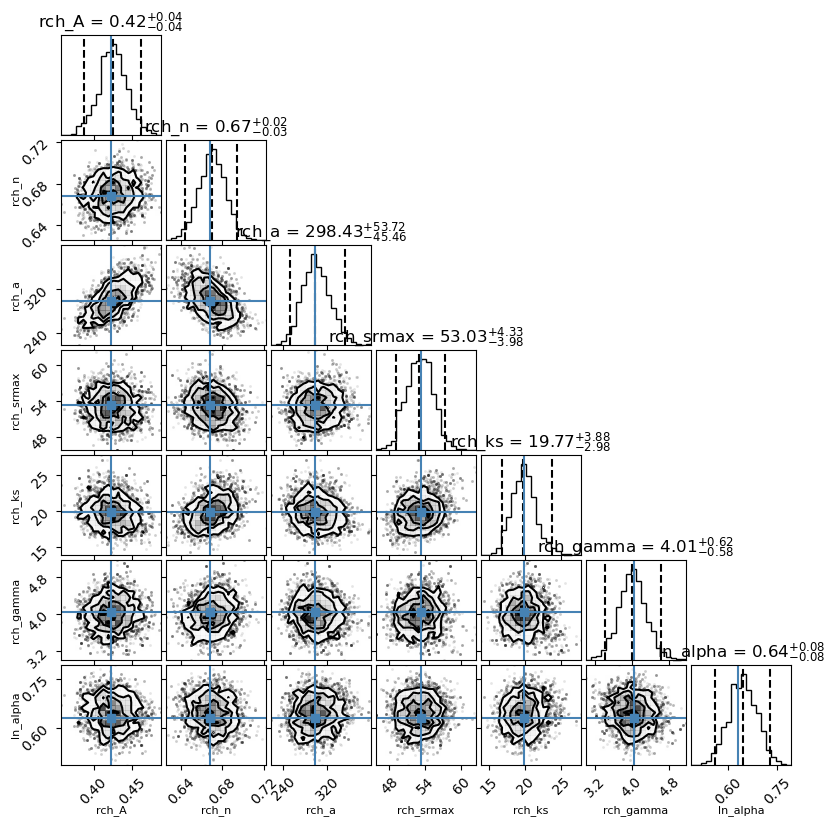

In [8]:
# Corner plot of the results
fig = plt.figure(figsize=(8, 8))

labels = list(ml.parameters.index[ml.parameters.vary]) + \
         list(ml.fit.parameters.index[ml.fit.parameters.vary])

best = list(ml.parameters[ml.parameters.vary == True].optimal) + \
       list(ml.fit.parameters[ml.fit.parameters.vary == True].optimal)

axes = corner.corner(
    ml.fit.sampler.get_chain(flat=True, discard=500),
    quantiles=[0.025, 0.5, 0.975],
    labelpad=0.1,
    show_titles=True,
    label_kwargs=dict(fontsize=8),
    max_n_ticks=3,
    fig=fig,
    labels=labels,
    truths=best,
)

plt.show()

## 4. What happens to the walkers at each step?
The walkers take steps in different directions for each step. It is expected that after a number of steps, the direction of the step becomes random, as a sign that an optimum has been found. This can be checked by looking at the autocorrelation, which should be insignificant after a number of steps. Below we just show how to obtain the different chains, the interpretation of which is outside the scope of this notebook.

Text(0.5, 0, 'step number')

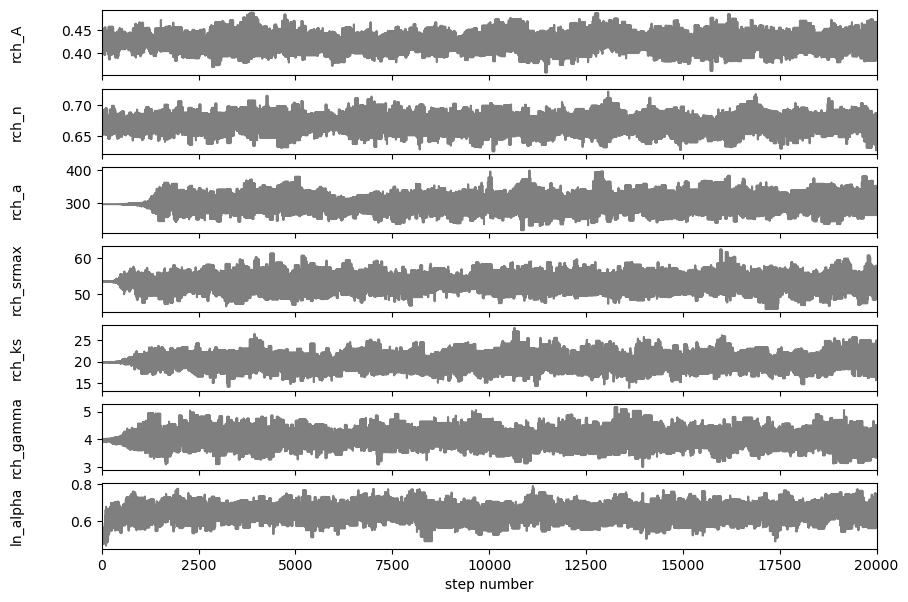

In [9]:
fig, axes = plt.subplots(len(labels), figsize=(10, 7), sharex=True)

samples = ml.fit.sampler.get_chain(flat=True)
for i in range(len(labels)):
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.5)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

## 5. Plot some simulated time series to display uncertainty?

We can now draw parameter sets from the chain and simulate the uncertainty in the head simulation.  

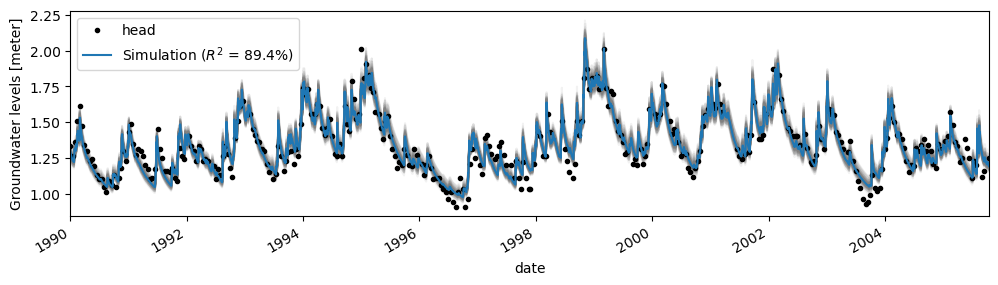

In [10]:
# Plot results and uncertainty
ax = ml.plot(figsize=(10,3))
plt.title(None)

chain = ml.fit.sampler.get_chain(flat=True, discard=500)
inds = np.random.randint(len(chain), size=100)
for ind in inds:
    params = chain[ind]
    p = ml.parameters.optimal.copy().values
    p[ml.parameters.vary] = params[: ml.parameters.vary.sum()]
    ml.simulate(p, tmin="1990").plot(c="gray", alpha=0.1, zorder=-1)
